# **March Machine Learning Mania 2025**

- reference link(1): https://www.kaggle.com/competitions/march-machine-learning-mania-2025
- reference link(2): https://www.kaggle.com/code/modeh7/final-solution-ncaa-2025

## **주제**

Forecast the 2025 NCAA Basketball Tournaments

## **데이터 설명**

1985년부터 현재까지의 남성/여성 대학농구 경기, 팀, 시즌, 토너먼트 관련 과거 데이터.

- 남성 데이터 파일은 **`M`**으로 시작.
- 여성 데이터 파일은 **`W`**로 시작.
- 일부 파일(`Cities.csv`, `Conferences.csv`)은 남녀 공통.

---

#### **주요 데이터셋**

데이터는 총 5개 섹션

* **섹션 1: 기본 정보**
    * `MTeams.csv`, `WTeams.csv`: 팀의 고유 ID와 이름. 남성 팀 ID는 1000번대, 여성 팀 ID는 3000번대이다.
    * `MSeasons.csv`, `WSeasons.csv`: 각 시즌의 정보와 날짜 기준점인 **`DayZero`**.
    * `MNCAATourneySeeds.csv`, `WNCAATourneySeeds.csv`: 토너먼트 참가 팀의 시드 정보.
    * `MRegularSeasonCompactResults.csv`, `WRegularSeasonCompactResults.csv`: 정규 시즌 경기 결과.
    * `MNCAATourneyCompactResults.csv`, `WNCAATourneyCompactResults.csv`: 토너먼트 경기 결과.
    * `SampleSubmissionStage1.csv`: 예측 결과를 제출할 때 사용해야 하는 파일 형식. `ID`와 `Pred` 두 개의 열로 구성되며, `Pred`는 첫 번째 팀이 승리할 확률이다.

* **섹션 2: 박스 스코어 상세**
    * `MRegularSeasonDetailedResults.csv`, `WRegularSeasonDetailedResults.csv`: 정규 시즌 경기당 득점, 리바운드, 어시스트 등 세부 통계 자료.
    * `MNCAATourneyDetailedResults.csv`, `WNCAATourneyDetailedResults.csv`: 토너먼트 경기당 세부 통계 자료.

* **섹션 3: 지리 정보**
    * `Cities.csv`: 경기 개최 도시 목록.
    * `MGameCities.csv`, `WGameCities.csv`: 각 경기가 열린 도시 정보.

* **섹션 4: 공개 랭킹**
    * `MMasseyOrdinals.csv`: 여러 랭킹 시스템(Pomeroy, Sagarin 등)에서 집계한 남성 팀 순위.

* **섹션 5: 보충 자료**
    * 코치, 컨퍼런스 소속, 팀명 철자, 토너먼트 대진 구조 등 예측 모델에 활용할 수 있는 추가 정보.

## **데이터 전처리**

### 1. 기본 데이터 전처리

데이터셋 크기를 두 배로 늘리고, 연장전에 따른 기록을 조정하며, 팀의 승패를 명확히 구분하는 특징을 생성

---

#### **1) 연장전(Overtime) 기록 조정**
  ```
  adjot = (40 + 5 * df["NumOT"]) / 40
  ```
  : 농구 정규 경기 시간은 40분이며, 연장전은 5분씩 추가됨을 고려하여 경기 기록 정규화

####  **2) 데이터 증강**
  ```
  dfswap.columns = [x.replace("L", "T1_").replace("W", "T2_") for x in list(dfswap.columns)]
  ```
  - df: 승리팀(W)의 열 이름을 T1_, 패배팀(L)의 열 이름을 T2_
  - dfswap: 패배팀(L)의 열 이름을 T1_로, 승리팀(W)의 열 이름을 T2_
  
  : "팀1(승) vs 팀2(패)"와 "팀1(패) vs 팀2(승)"이라는 두 개의 관점을 가진 행을 생성하여 데이터셋을 두 배로 만듦

####  **3) 파생변수 생성**
  - PointDiff (점수 차이)
  ```
  output["PointDiff"] = output["T1_Score"] - output["T2_Score"]
  ```
  : T1_Score에서 T2_Score를 뺀 값이다.

  - win (승패)
  ```
  output["win"] = (output["PointDiff"] > 0) * 1
  ```  
  : PointDiff가 0보다 크면 1, 아니면 0으로 설정한다. 이 열은 모델이 예측해야 할 타겟 변수가 된다.

  - men_women (남성/여성 경기)
  ```
  output["men_women"] = (output["T1_TeamID"].apply(lambda t: str(t).startswith("1"))) * 1
  ```
  : T1_TeamID가 1000번대(남성)이면 1, 아니면 0으로 이진으로 설정

### 2. Easy difficulty features

#### **시드 번호 추출**

```
# extract seed number from `Seed` field
seeds["seed"] = seeds["Seed"].apply(lambda x: int(x[1:3]))
seeds
```

```
tourney_data = tourney_data[["Season", "T1_TeamID", "T2_TeamID", "PointDiff", "win", "men_women"]]
tourney_data = pd.merge(tourney_data, seeds_T1, on=["Season", "T1_TeamID"], how="left")
tourney_data = pd.merge(tourney_data, seeds_T2, on=["Season", "T2_TeamID"], how="left")
```

- 'Seed'에서 seed number를 뽑아 위에서 가공한 데이터에 concat함.

```
tourney_data["Seed_diff"] = tourney_data["T2_seed"] - tourney_data["T1_seed"]
```

- difference between T2's seed number and T1's 파생변수 생성

### 3. Medium difficulty features

#### **정규 시즌 평균 기록 계산**

```
# calculate season averages
ss = regular_data.groupby(["Season", "T1_TeamID"])[boxcols].agg("mean").reset_index()
```
: 정규 시즌 데이터를 'Season', 'T1_TeamID'를 기준으로 그룹화 후, boxcols에 정의된 모든 박스 스코어 통계(FGM, FGA, Score 등)에 대해 평균을 계산. --> 그룹화된 결과를 데이터프레임으로 다시 생성(결과 = ss)

```
ss_T1 = ss.copy()
ss_T1.columns = ["T1_avg_" + x.replace("T1_", "").replace("T2_", "opponent_") for x in list(ss_T1.columns)]
ss_T1 = ss_T1.rename({"T1_avg_Season": "Season", "T1_avg_TeamID": "T1_TeamID"}, axis=1)
ss_T2 = ss.copy()
ss_T2.columns = ["T2_avg_" + x.replace("T1_", "").replace("T2_", "opponent_") for x in list(ss_T2.columns)]
ss_T2 = ss_T2.rename({"T2_avg_Season": "Season", "T2_avg_TeamID": "T2_TeamID"}, axis=1)
```
: 팀별 평균 기록 열 이름 변경 코드

```
tourney_data = pd.merge(tourney_data, ss_T1, on=["Season", "T1_TeamID"], how="left")
tourney_data = pd.merge(tourney_data, ss_T2, on=["Season", "T2_TeamID"], how="left")
tourney_data
```
: 토너먼트 데이터에 평균 기록 병합

### 4. Hard difficulty features

#### **Elo 등급 시스템을 이용한 각 팀의 경기력 순위 변수**

```
def expected_result(elo_a, elo_b):
    return 1.0 / (1 + 10 ** ((elo_b - elo_a) / elo_width))
```
: 팀 A와 팀 B의 Elo 등급을 바탕으로 팀 A의 예상 승률을 계산
- 등급 차이가 클수록 예상 승률은 0 또는 1에 가까워짐

```
def update_elo(winner_elo, loser_elo):
    expected_win = expected_result(winner_elo, loser_elo)
    change_in_elo = k_factor * (1 - expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo
```
: 경기 후 Elo 등급 업데이트 함수
- `k_factor`: 등급 편화 폭을 결정하는 상수
- `change_in_elo`: 실제 결과와 예상 결과의 차이를 반영하여 등급 변화량을 계산
- 승리팀은 점수가 올라가고, 패배팀은 점수가 내려간다.

```
base_elo = 1000
elo_width = 400
k_factor = 100

elos = []
for season in sorted(set(seeds["Season"])): # 데이터에 있는 모든 시즌에 대해 반복
    ss = regular_data.loc[regular_data["Season"] == season]
    ss = ss.loc[ss["win"] == 1].reset_index(drop=True) # 해당 시즌의 정규 시즌 데이터를 가져와 승리팀이 포함된 행만 필터링
    teams = set(ss["T1_TeamID"]) | set(ss["T2_TeamID"]) # 해당 시즌에 경기를 치른 모든 팀의 ID 추출
    elo = dict(zip(teams, [base_elo] * len(teams))) # 해당 시즌에 참가하는 모든 팀의 Elo 등급을 초기값 1000 설정
    for i in range(ss.shape[0]): # 해당 시즌의 모든 경기에 대해 반복
        w_team, l_team = ss.loc[i, "T1_TeamID"], ss.loc[i, "T2_TeamID"] # 승리팀과 패배팀의 ID
        w_elo, l_elo = elo[w_team], elo[l_team] # 현재 Elo 등급
        w_elo_new, l_elo_new = update_elo(w_elo, l_elo) # update_elo 함수를 호출하여 새로운 Elo 등급 계산
        # 계산된 새로운 등급으로 딕셔너리 업데이트
        elo[w_team] = w_elo_new
        elo[l_team] = l_elo_new
    elo = pd.DataFrame.from_dict(elo, orient="index").reset_index()
    elo = elo.rename({"index": "TeamID", 0: "elo"}, axis=1)
    elo["Season"] = season
    elos.append(elo)
elos = pd.concat(elos)
```
: 시즌별 Elo 등급 계산 코드

```
elos_T1 = elos.copy().rename({"TeamID": "T1_TeamID", "elo": "T1_elo"}, axis=1)
elos_T2 = elos.copy().rename({"TeamID": "T2_TeamID", "elo": "T2_elo"}, axis=1)
tourney_data = pd.merge(tourney_data, elos_T1, on=["Season", "T1_TeamID"], how="left")
tourney_data = pd.merge(tourney_data, elos_T2, on=["Season", "T2_TeamID"], how="left")
tourney_data["elo_diff"] = tourney_data["T1_elo"] - tourney_data["T2_elo"]
```
: Elo 등급 계산 후 토너먼트 데이터에 병합

### 5. Hardest difficulty features

#### **일반화 선형 모델(GLM)을 이용하여 시즌별 실력(quality) 계산**

```
import statsmodels.api as sm
import tqdm
```

```
regular_data["ST1"] = regular_data.apply(lambda t: str(int(t["Season"])) + "/" + str(int(t["T1_TeamID"])), axis=1)
regular_data["ST2"] = regular_data.apply(lambda t: str(int(t["Season"])) + "/" + str(int(t["T2_TeamID"])), axis=1)
```
: `Season`과 `TeamID`를 결합하여 고유 식별자(`ST1`,`ST2`) 생성
```
seeds_T1["ST1"] = seeds_T1.apply(lambda t: str(int(t["Season"])) + "/" + str(int(t["T1_TeamID"])), axis=1)
seeds_T2["ST2"] = seeds_T2.apply(lambda t: str(int(t["Season"])) + "/" + str(int(t["T2_TeamID"])), axis=1)

# collect tourney teams
st = set(seeds_T1["ST1"]) | set(seeds_T2["ST2"])
```
: 토너먼트에 참가한 모든 팀의 고유 식별자를 `st` 집합에 모음
```
# append non-tourney teams which were able to beat tourney team at least once
st = st | set(regular_data.loc[(regular_data["T1_Score"] > regular_data["T2_Score"]) &
                               (regular_data["ST2"].isin(st)), "ST1"])
```
: 토너먼트 참가 팀을 상대로 최소 한 번이라도 이긴 비토너먼트 팀을 추가
- 모델이 더 많은 데이터를 학습하도록 도움
```
def team_quality(season, men_women):
    # mixed effects: fixed intercept=0, random slope
    formula = "PointDiff~-1+T1_TeamID+T2_TeamID"
    # 일반화 선형 모델(GLM) 정의
    glm = sm.GLM.from_formula(
        formula=formula,
        data=dt.loc[(dt["Season"] == season) & (dt["men_women"] == men_women), :],
        family=sm.families.Gaussian(),
    ).fit()

    quality = pd.DataFrame(glm.params).reset_index() # 학습된 모델에서 각 팀 ID에 해당하는 계수(실력 점수)를 추출하여 데이터프레임 생성
    quality.columns = ["TeamID", "quality"]
    quality["quality"] = quality["quality"]
    quality["Season"] = season
    quality = quality.loc[quality.TeamID.str.contains("T1_")].reset_index(drop=True)
    quality["TeamID"] = quality["TeamID"].apply(lambda x: x[10:14]).astype(int) # 추출된 계수 데이터프레임에서 '팀1'의 계수만 남기고 팀 ID를 정수형 변환
    return quality
```
: 팀 실력(quality) 계산 함수 코드
- formula = "PointDiff~-1+T1_TeamID+T2_TeamID"

  --> `PointDiff`를 종속 변수, `T1_TeamID`, `T2_TeamID`를 독립 변수로 회귀 모델을 학습하는 것을 의미 --> `-1`은 intercept를 없애고, 각 팀의 ID에 해당하는 계수(coefficients)만 추정

  --> 해당 계수: 팀의 상대적인 실력 점수

- sm.families.Gaussion()

  --> 오차 분포를 가우시안(정규) 분포로 가정
  - `Pointdiff`가 연속 값이기 때문

```
glm_quality = []

dt = regular_data.loc[regular_data["ST1"].isin(st) | regular_data["ST2"].isin(st)]
dt["T1_TeamID"] = dt["T1_TeamID"].astype(str)
dt["T2_TeamID"] = dt["T2_TeamID"].astype(str)
dt.loc[~dt["ST1"].isin(st), "T1_TeamID"] = "0000"
dt.loc[~dt["ST2"].isin(st), "T2_TeamID"] = "0000"
seasons = sorted(set(seeds["Season"]))

for s in tqdm.tqdm(seasons, unit="season"): # 모든 시즌에 대해 team_quality 함수 실행 --> 팀 실력 점수 데이터프레임 리스트(glm_quality) 생성 + 남성 및 여성 데이터의 시작 시즌을 구분하여 처리
    if s >= 2010:  # min season for women
        glm_quality.append(team_quality(s, 0))
    if s >= 2003:  # min season for men
        glm_quality.append(team_quality(s, 1))

glm_quality = pd.concat(glm_quality).reset_index(drop=True) # 모든 시즌의 실력 점수 데이터를 하나로 합침
```

```
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
# 병합을 위해 column 이름 변경
glm_quality_T1.columns = ["T1_TeamID", "T1_quality", "Season"]
glm_quality_T2.columns = ["T2_TeamID", "T2_quality", "Season"]
tourney_data = pd.merge(tourney_data, glm_quality_T1, on=["Season", "T1_TeamID"], how="left")
tourney_data = pd.merge(tourney_data, glm_quality_T2, on=["Season", "T2_TeamID"], how="left")
tourney_data["diff_quality"] = tourney_data["T1_quality"] - tourney_data["T2_quality"]
```
: 병합 코드

## **모델링**

### 독립 변수

```
features = [
    ### EASY FEATURES ###
    "men_women",    
    "T1_seed",
    "T2_seed",
    "Seed_diff",
    ### MEDIUM FEATURES ###
    "T1_avg_Score",
    "T1_avg_FGA",
    "T1_avg_OR",
    "T1_avg_DR",
    "T1_avg_Blk",
    "T1_avg_PF",
    "T1_avg_opponent_FGA",
    "T1_avg_opponent_Blk",
    "T1_avg_opponent_PF",
    "T1_avg_PointDiff",
    "T2_avg_Score",
    "T2_avg_FGA",
    "T2_avg_OR",
    "T2_avg_DR",
    "T2_avg_Blk",
    "T2_avg_PF",
    "T2_avg_opponent_FGA",
    "T2_avg_opponent_Blk",
    "T2_avg_opponent_PF",
    "T2_avg_PointDiff",
    ### HARD FEATURES ###
    "T1_elo",
    "T2_elo",    
    "elo_diff",
    ### HARDEST FEATURES ###
    "T1_quality",
    "T2_quality",
]
```

### XGBoost

#### 하이퍼파라미터

```
import xgboost as xgb

param = {}
param["objective"] = "reg:squarederror"
param["booster"] = "gbtree"
param["eta"] = 0.0093  #0.009 #0.01
param["subsample"] = 0.6
param["colsample_bynode"] = 0.8
param["num_parallel_tree"] = 2
param["min_child_weight"] = 4
param["max_depth"] = 4
param["tree_method"] = "hist"
param['grow_policy'] = 'lossguide'
param["max_bin"] = 38   #32

num_rounds = 704 #704 #700
```

#### Leave-One-Season-Out 교차 검증
- 각 Season을 한 번씩 검증 데이터로 사용하고, 나머지 시즌을 훈련 데이터로 사용하여 모델을 훈련 및 평
```
from sklearn.metrics import mean_absolute_error, brier_score_loss

models = {}
oof_mae = []
oof_preds = []
oof_targets = []
oof_ss = []

# leave-one-season out models
for oof_season in set(tourney_data.Season):
    # 현재 oof_season을 제외한 모든 시즌의 데이터를 훈련 데이터로 사용
    x_train = tourney_data.loc[tourney_data["Season"] != oof_season, features].values
    y_train = tourney_data.loc[tourney_data["Season"] != oof_season, "PointDiff"].values
    # 현재 oof_season을 검증 데이터로 사용
    x_val = tourney_data.loc[tourney_data["Season"] == oof_season, features].values
    y_val = tourney_data.loc[tourney_data["Season"] == oof_season, "PointDiff"].values
    s_val = tourney_data.loc[tourney_data["Season"] == oof_season, "Season"].values
    
    # XGBoost 모델 --> 자체 데이터 구조 DMatrix 사용
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dval = xgb.DMatrix(x_val, label=y_val)
    # 훈련된 모델을 딕셔너리에 저장
    models[oof_season] = xgb.train(
        params=param,
        dtrain=dtrain,
        num_boost_round = num_rounds,        
    )
    preds = models[oof_season].predict(dval)
    print(f"oof season {oof_season} mae: {mean_absolute_error(y_val, preds)}")
    oof_mae.append(mean_absolute_error(y_val, preds))
    oof_preds += list(preds)
    oof_targets += list(y_val)
    oof_ss += list(s_val)
    
print(f"average mae: {np.mean(oof_mae)}")
```

### 대회 평가 방식에 맞는 데이터 가공

```
df = pd.DataFrame(
    {"Season": oof_ss, "pred": oof_preds, "label": [(t > 0) * 1 for t in oof_targets], "men_women": tourney_data["men_women"]}
)
df["pred_pointdiff"] = df["pred"].astype(int)


# 모든 경기 데이터를 그룹화
# 각 그룹의 평균 실제 승리 확률 계산
xdf_all = df.clip(-30, 30).groupby("pred_pointdiff")["label"].mean().reset_index(name="average_win_pct")
xdf_men = df.clip(-30, 30).loc[df["men_women"] == 0].groupby("pred_pointdiff")["label"].mean().reset_index(name="average_win_pct")
xdf_women = df.clip(-30, 30).loc[df["men_women"] == 1].groupby("pred_pointdiff")["label"].mean().reset_index(name="average_win_pct")

seaborn.lineplot(x=xdf_all["pred_pointdiff"], y=xdf_all["average_win_pct"])
seaborn.lineplot(x=xdf_men["pred_pointdiff"], y=xdf_men["average_win_pct"])
seaborn.lineplot(x=xdf_women["pred_pointdiff"], y=xdf_women["average_win_pct"])
```

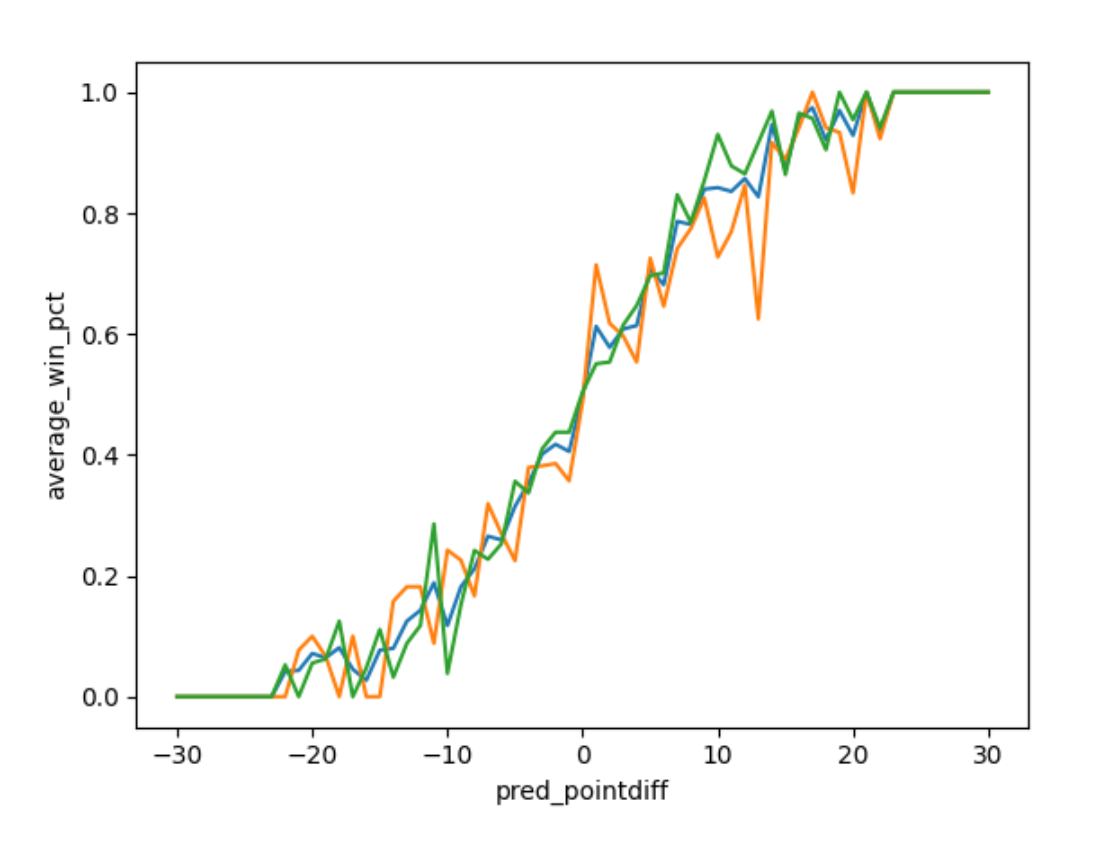

- XGBoost 모델의 교차 검증 예측 결과(`oof_preds`)와 실제 결과(`oof_targets`)를 담은 새로운 데이터프레임 df를 생성
- `df["label"]`: 실제 경기 결과(oof_targets)를 승리(1) 또는 패배(0)의 이진 값으로 변환

  -->점수 차이가 0보다 크면 승리(1), 아니면 패배(0)
- 모델이 예측한 점수 차이를 정수로 변환

- `df.clip(-30, 30)`: 예측 점수 차이 값을 -30에서 30 사이로 제한

  --> 극단적인 예측값 제거



```
from scipy.interpolate import UnivariateSpline

t = 25

dat = list(zip(oof_preds, np.array(oof_targets)>0))
dat = sorted(dat, key = lambda x: x[0])
pred, label = list(zip(*dat))
spline_model = UnivariateSpline(np.clip(pred, -t, t), label, k=5)
spline_fit = np.clip(spline_model(np.clip(oof_preds, -t, t)), 0.01, 0.99)
print(f"brier: {brier_score_loss(np.array(oof_targets)>0, spline_fit)}")
df["spline"] = spline_fit
xdf = df.clip(-30,30).groupby('pred_pointdiff')[['spline','label']].mean().reset_index()

plt.figure()
plt.plot(xdf['pred_pointdiff'],xdf['label'])
plt.plot(xdf['pred_pointdiff'],xdf['spline'])
```
- XGBoost 모델이 예측한 점수 차이(`oof_preds`)와 실제 승패 결과(`oof_targets`를 승리/패배 이진 값으로 변환)를 한 쌍으로 묶음
- 스플라인 보정을 위해 이 데이터 쌍을 예측값(`oof_preds`)을 기준으로 정렬

#### 스플라인(Spline) 모델
- `UnivariateSpline` 함수를 사용하여 **예측된 점수 차이**(X축)와 **실제 승리 확률*(Y축) 사이의 관계를 나타내는 부드러운 곡선 생성
  - 이 곡선은 모델이 예측한 특정 점수 차이가 실제로 몇 퍼센트의 승률로 이어지는지를 학습

--> ex) 모델이 10점 차이로 승리한다고 예측한 모든 경기의 실제 승률이 80%라면, 스플라인 곡선은 예측값 10에 대해 0.8의 확률을 매핑한다.


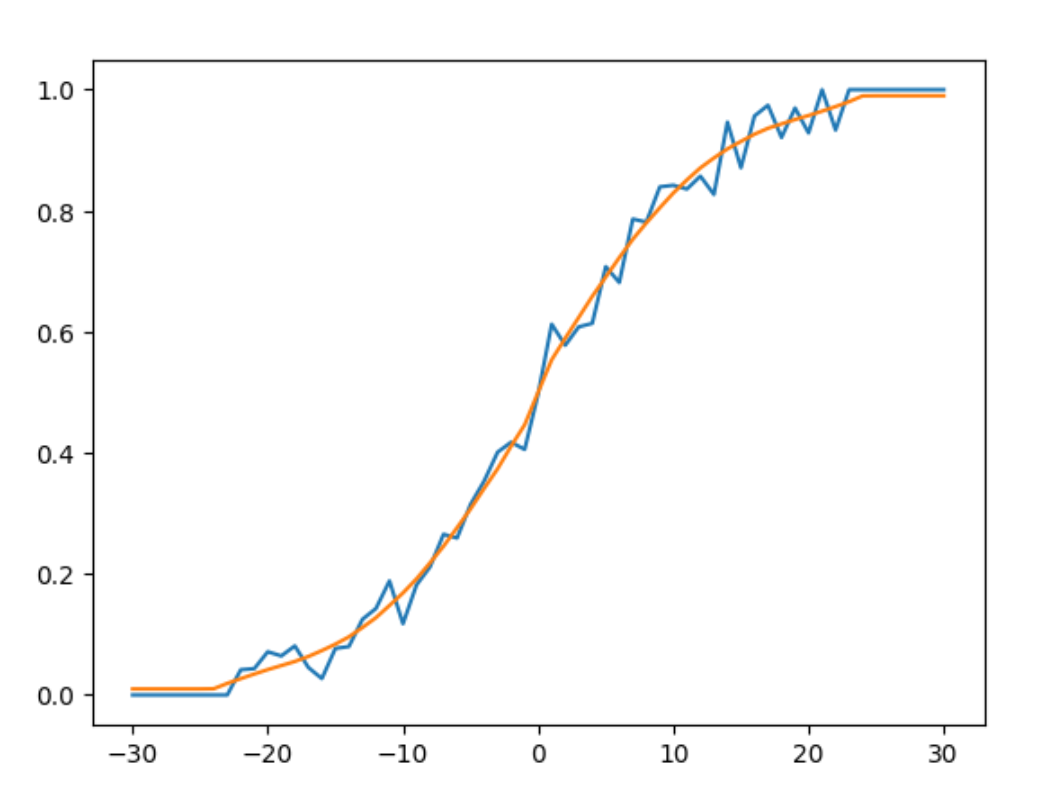

- XGBoost 모델의 예측 결과(점수 차이)를 **경기 승리 확률**로 변환하기 위해 Spline 보정 수행

  - 첫 번째 그래프: 실제 데이터의 승리 확률

    --> 예측 점수 차이별로 실제 승률을 나타내므로 불규칙하게 보일 수 있음

  - 두 번째 그래프: 스플라인(Spline) 모델이 예측한 승리 확률

    --> 첫 번째 선의 전체적인 추세를 따르며 부드러운 형태로 나타남

---

모델의 회귀 예측(점수 차이)을 확률적 예측(승리 확률)으로 변환할 수 있으며 대회의 제출 형식에 맞추고 예측의 신뢰도를 높임

## **배울 점**

### 1. 주제에 알맞은 데이터 전처리 과정

```
# adjustment factor for overtimes, as more stats are accumulated during overtimes
    adjot = (40 + 5 * df["NumOT"]) / 40
    adjcols = ["LScore", "WScore",
               "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF",
               "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF"]
    for col in adjcols:
        df[col] = df[col] / adjot
```

- `adjot` --> 경기 기록을 경기 시간 기준으로 정규화하는 조정 계수로, 실제 농구 정규 경기 시간은 40분이고 연장전으로 이어질 시에 5분이 추가됨을 반영하여 계수를 생성.

- `adjcols`를 adjot 계수를 사용하여 연장전 유무에 관계없이 **모든 경기 기록을 40분 기준으로 통일**시켜 모델이 공정하게 비교할 수 있도록 도왔음

즉, 농구 토너먼트를 예측하는 대회인만큼 실제 농구 경기의 시간을 적용시켜 새로운 방법을 적용하여 각 농구 경기 기록을 정규화함.

--> 모델의 성능을 높일 수 있는 방법을 새롭게 배울 수 있었음.

### 2. 검토의 중요성

```
# let's take an example match to double check if the same match is entered correctly in our dataset
season = regular_data["Season"] == 2025
t1, t2 = 1182, 1433
match1 = (regular_data["T1_TeamID"] == t1) & (regular_data["T2_TeamID"] == t2)
match2 = (regular_data["T1_TeamID"] == t2) & (regular_data["T2_TeamID"] == t1)
regular_data.loc[season & (match1 | match2)]
```

- 랜덤으로 연도(Season), 팀 번호(TeamID) 등을 골라 전처리 후에도 데이터가 알맞게 들어가있는지 확인하는 과정을 거침.

--> 전처리 과정에서 범할 수 있는 몇몇 데이터가 삭제되거나 오류가 생기는 등의 문제들을 막을 수 있는 좋은 습관이 될 수 있음

### 3. 전처리 후 평가

```
tmp["QualitySeed"] = (

(tmp.groupby(["Season", "men_women"])["T1_quality"].rank(ascending=False) // 4 + 1).clip(1, 16).astype(int))pd.pivot_table(data=tmp, index="T1_seed", columns="QualitySeed", values="men_women", aggfunc="count").fillna(0).astype(int).style.bar(color="#5fba7d", vmin=0, vmax=50)
```

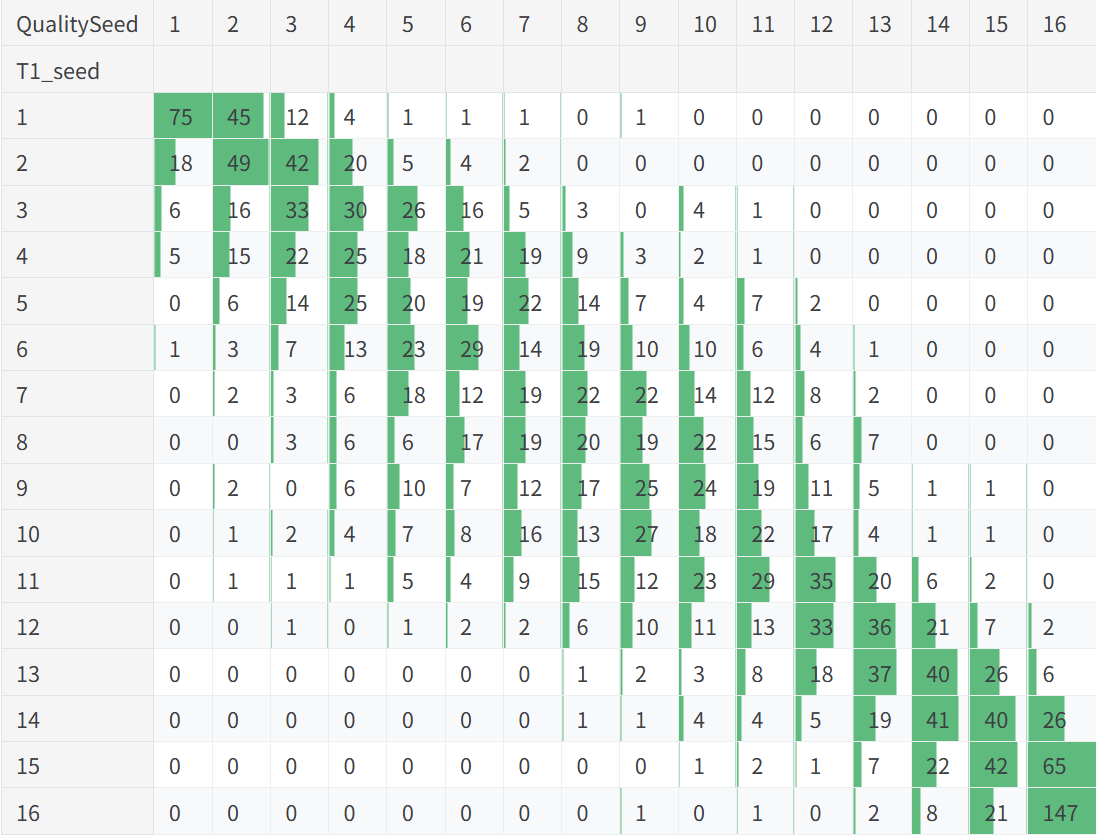

위는 5. Hardest Difficulty Features에서 도출해낸 팀의 실력 점수(`T1_quality`)를 바탕으로 예상 시드를 계산하여 실제 시드와 비교한 pivot table 표 이미지이다.

- `["T1_quality"].rank(ascending=False)// 4 + 1` --> `T1_quality` 점수를 기준으로 순위를 매긴 뒤 4개씩 묶어 시드 번호 부여 (ex. 1 ~ 4등은 시드 1, 5 ~ 8등은 시드 2)

- `.clip(1, 16)` --> 계산된 시드 번호를 1 - 16으로 제한

해당 pivot table을 통해 GLM 모델이 정규 시즌 경기력(quality)을 바탕으로 토너먼트 시드를 잘 예측하고 있음을 확인

#### 1. Seed diff의 예측력
```
roc_auc_score(1 - tourney_data["win"], tourney_data["T1_seed"] - tourney_data["T2_seed"])
```
- Seed만으로도 경기 결과를 얼마나 잘 예측할 수 있는지

  + roc_auc_score 함수는 예측 변수(T1_seed - T2_seed)와 타겟 변수(win)의 상관관계 방향이 일치해야함
  
  --> 시드 차이(T1_seed - T2_seed)는 음수일 때 T1 팀의 승리 확률이 높아지지만, win 변수는 1일 때 T1 팀 승리이므로, 이 둘의 상관관계는 반대!
  
  --> 1 - win으로 타겟 변수의 방향을 바꿔 상관관계를 일치시킴

#### 2. Quality diff의 예측력
```
roc_auc_score(tourney_data["win"], tourney_data["T1_quality"] - tourney_data["T2_quality"])
```
- GLM 모델로 계산한 실력 점수가 경기 결과를 얼마나 잘 예측하는지 보여줌

---

#### 해당 평가에서 AUC를 사용한 이유
- AUC는 단순히 예측이 맞았는지 틀렸는지를 따지는 것보다, 모델이 얼마나 신뢰성 있는 순위를 매기는 지를 평가하는데 유용하기 때문에 사용한 것으로 추측

#### 토너먼트 시드(experts)와 통계 모델로 계산한 팀 실력(quality)의 경기 결과 예측력 평가

```
# who is better, experts or statistics, by season
for s in sorted(set(tourney_data['Season'])):
    st = tourney_data['Season'] == s
    print(s,
          a:=np.round(roc_auc_score(1-tourney_data.loc[st, "win"],tourney_data.loc[st, 'T1_seed'] - tourney_data.loc[st, 'T2_seed']),3),
          b:=np.round(roc_auc_score(tourney_data.loc[st, "win"],tourney_data.loc[st, 'T1_quality'] - tourney_data.loc[st, 'T2_quality']),3),
          np.where(a>b, '', 'Q')
         )
```
: 전문가(시드)와 통계(실력 점수)의 예측 능력을 매년 비교하여, 어느 쪽의 에측이 더 정확했는지 확인하여 만들어낸 파생변수의 예측력이 좋은 지 판단

### 4. 데이터 선택

해당 대회에서 주어진 데이터 파일들이 상당히 많은 편이었는데, 이 중 필요한 데이터가 무엇인지 스스로 판단하고 선택하는 것이 중요함을 확인.

실무나 다른 대회에서도 많은 데이터 중 스스로 판단하고 사용할 데이터를 선택해야할 때가 많을텐데, 이에 대한 중요성을 다시금 깨달음.